In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def dydx(x,y):
    
    #dydx = z
    #dzdx = -y
    

    #y = y[0]
    #z = y[1]
    
    #make array
    y_derivs = np.zeros(2)
                       
    #def deriv
    y_derivs[0] = y[1]
    
    #def deriv
    y_derivs[1] = -1*y[0]
    
    #return array
    return y_derivs


In [12]:
def rk4_mv_core(dydx,xi,yi,nv,h):
    
    #k arrays
    k1 = np.zeros(nv)  
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    k5 = np.zeros(nv)
    k6 = np.zeros(nv)
    
    
    #temp y array
    y_temp = np.zeros(nv)
    
    #defining a, b, b*, c values
    c2 = 1/5
    c3 = 3/10
    c4 = 3/5
    c5 = 1
    c6 = 7/8
    
    a21 = 1/5
    a31 = 3/40
    a41 = 3/10
    a51 = -11/54
    a61 = 1631/55296
    
    a32 = 9/40
    a42 = -9/10
    a52 = 5/2
    a62 = 175/512
    
    a43 = 6/5
    a53 = -70/27
    a63 = 575/13824
    
    a54 = 35/27
    a64 = 44275/110592
    
    a65 = 253/4096
    
    b1 = 37/378
    b2 = 0
    b3 = 250/621
    b4 = 125/594
    b5 = 0
    b6 = 512/1771
    
    b1star = 2825/27648
    b2star = 0
    b3star = 18575/48384
    b4star = 13525/55296
    b5star = 277/14336
    b6star = 1/4
    
       
    #k1 values
    y_derivs = dydx(xi,yi)
    k1[:] = h*y_derivs[:]
    
    #k2 values
    y_temp[:] = yi[:] + a21*k1[:]
    y_derivs = dydx(xi + c2*h, y_temp)
    k2[:] = h*y_derivs[:]
    
    #k3 values
    y_temp[:] = yi[:] + a31*k1[:] + a32*k2[:]
    y_derivs = dydx(xi+c3*h,y_temp)
    k3[:] = h*y_derivs[:]
    
    #k4 values 
    y_temp[:] = yi[:] + a41*k1[:] + a42*k2[:] + a43*k3[:]
    y_derivs = dydx(xi + c4*h,y_temp)
    k4[:] = h*y_derivs[:]
    
    #k5 values
    y_temp[:] = yi[:] + a51*k1[:] + a52*k2[:] + a53*k3[:] + a54*k4[:]
    y_derivs = dydx(xi + c5*h,y_temp)
    k5[:] = h*y_derivs[:]
    
    #k6 values
    y_temp[:] = yi[:] + a61*k1[:] + a62*k2[:] + a63*k3[:] + a64*k4[:] + a65*k5[:]
    y_derivs = dydx(xi + c6*h,y_temp)
    k6[:] = h*y_derivs[:]
    
    #error analysis
    yipo = yi + b1*k1 + b2*k2 + b3*k3 + b4*k4 + b5*k5 + b6*k6
    
    yipostar = yi + b1star*k1 + b2star*k2 + b3star*k3 + b4star*k4 + b5star*k5 + b6star*k6
    
    return yipo

In [13]:
def rk4_mv_ad(dydx,x_i,y_i,nv,h,tol):
    
    #safety scale
    SAFETY    = 0.9
    H_NEW_FAC = 2.0
    
    #max iterations
    imax = 10000
    
    #i initial
    i = 0
    
    #error value
    Delta = np.full(nv,2*tol)
    
    #step tracker
    h_step = h
    
    #adjust step
    while(Delta.max()/tol > 1.0):
        
        #estimate error with one step of h compared to two steps of h/2
        y_2 = rk4_mv_core(dydx,x_i,y_i,nv,h_step)
        y_1 = rk4_mv_core(dydx,x_i,y_i,nv,0.5*h_step)
        y_11 = rk4_mv_core(dydx,x_i+0.5*h_step,y_1,nv,0.5*h_step)
        
        #error
        Delta = np.fabs(y_2 - y_11)
        
        #check size of error
        if(Delta.max()/tol > 1.0):
            
            #decrease step size to reduce error
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
            
        #iteration counter
        if(i>=imax):
            print("Too many iterations in rk4_mv_ad()")
            raise StopIteration("Ending after i = ",i)
            
        #add iteration
        i+=1
        
    #attempt with larger step
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    # return the answer, a new step, and the step we actually took
    return y_2, h_new, h_step

In [14]:
def rk4_mv(dfdx,a,b,y_a,tol):
    
    #dfdx is the derivative of wrt x
    #a = lower bound
    #b = upper bound
    #y_a are the boundary conditions
    #tol is the tolerance
    
    #define our starting step
    xi = a
    yi = y_a.copy()
    
    #small initial step size
    h = 1.0e-4 * (b-a)
    
    #max iterations
    imax = 10000
    
    #iteration var
    i = 0
    
    #set the number of coupled odes to the size of y_a
    nv = len(y_a)
    
    #set the initial conditions
    x = np.full(1,a)
    y = np.full((1,nv),y_a)
    
    #set a flag
    flag = 1
    
    #loop untill we reach the right side
    while(flag):
        
        #calculate y_i+1
        yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
        
        #update the new step
        h = h_new
        
        #prevent an overshoot
        if(xi+h_step>b):
            
            #take a smaller step
            h = b-xi
            
            #recalculate y_i+1
            yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
            
            #break
            flag = 0
            
        #update values
        xi += h_step
        yi[:] = yi_new[:]
        
        #add the step to the arrays
        x = np.append(x,xi)
        y_new = np.zeros((len(x),nv))
        y_new[0:len(x)-1,:] = y
        y_new[-1,:] = yi[:]
        del y
        y = y_new
        
        # prevent too many iterations
        if(i>=imax):
            
            print("maximum iterations reached.")
            raise StopIteration("Iteration number = ",i)
            
        #iterate
        i += 1
        
        #output some information
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb=%9.8f" % (i,xi,h_step, b)
        print(s)
        
        #break if new xi is == b
        if(xi==b):
            flag = 0
    
    #return the answer
    return x,y


In [15]:
a = 0.0
b = 2.0 * np.pi
y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2
tolerance = 1.0e-6
x,y = rk4_mv(dydx,a,b,y_0,tolerance)


i =   1	x = 0.00062832	h = 0.00062832	b=6.28318531
i =   2	x = 0.00188496	h = 0.00125664	b=6.28318531
i =   3	x = 0.00439823	h = 0.00251327	b=6.28318531
i =   4	x = 0.00942478	h = 0.00502655	b=6.28318531
i =   5	x = 0.01947787	h = 0.01005310	b=6.28318531
i =   6	x = 0.03958407	h = 0.02010619	b=6.28318531
i =   7	x = 0.07979645	h = 0.04021239	b=6.28318531
i =   8	x = 0.16022123	h = 0.08042477	b=6.28318531
i =   9	x = 0.32107077	h = 0.16084954	b=6.28318531
i =  10	x = 0.64276986	h = 0.32169909	b=6.28318531
i =  11	x = 0.95166461	h = 0.30889476	b=6.28318531
i =  12	x = 1.26805818	h = 0.31639356	b=6.28318531
i =  13	x = 1.58812907	h = 0.32007089	b=6.28318531
i =  14	x = 1.92439441	h = 0.33626534	b=6.28318531
i =  15	x = 2.23091949	h = 0.30652508	b=6.28318531
i =  16	x = 2.54903350	h = 0.31811400	b=6.28318531
i =  17	x = 2.86042607	h = 0.31139258	b=6.28318531
i =  18	x = 3.18409468	h = 0.32366861	b=6.28318531
i =  19	x = 3.51559780	h = 0.33150312	b=6.28318531
i =  20	x = 3.82438660	h = 0.30

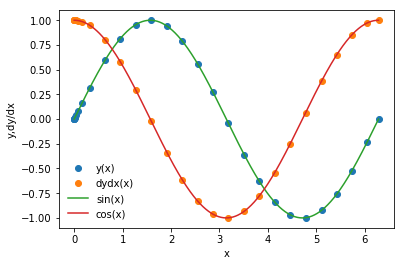

In [16]:
plt.plot(x,y[:,0],'o',label='y(x)')
plt.plot(x,y[:,1],'o',label='dydx(x)')
xx = np.linspace(0,2.0*np.pi,1000)
plt.plot(xx,np.sin(xx),label='sin(x)')
plt.plot(xx,np.cos(xx),label='cos(x)')
plt.xlabel('x')
plt.ylabel('y,dy/dx')
plt.legend(frameon=False)

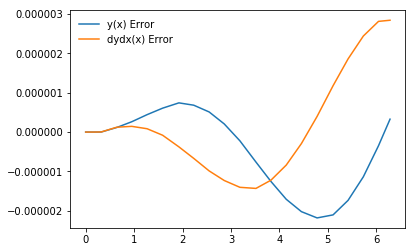

In [17]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0]-sine)
dydx_error = (y[:,1]-cosine)

plt.plot(x, y_error, label='y(x) Error')
plt.plot(x, dydx_error, label ="dydx(x) Error")
plt.legend(frameon=False)
